#3.1 MNIST

사이킷런의 여러 헬퍼 함수를 사용해서 잘 알려진 데이터셋을 내려받을 수 있음..

대부분 딕셔너리 구조를 가지고 있는데, 우리가 필요한 것은 'data', 'target'이다

In [1]:
#MNIST 내려 받기..

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
#가져오기..
#70000개의 샘플, 각 샘플당 픽셀이 28*28

X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


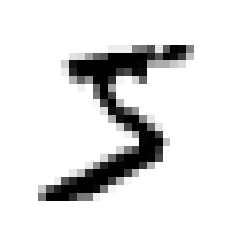

In [3]:
#하나만 확인 한번 해보자..

import matplotlib.pyplot as plt

first_data = X[0]
first_data_image = first_data.reshape(28,28)
plt.imshow(first_data_image, cmap="binary")
plt.axis('off')
plt.show()

In [4]:
#레이블 한번 확인.. 문자열이다..

print(type(y[0]))

<class 'str'>


In [5]:
#레이블이 문자열이니까 숫자로 바꾼다..
import numpy as np

y = y.astype(np.uint8)

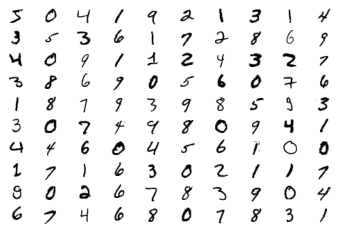

In [6]:
#그림 출력하는 함수 함 만들어보자..
#항상 N이 10의 배수임을 가정..
#혼공머 draw_fruits함수 응용..

def display_image(N):
    displaying_data = X[:N]
    displaying_data_image = displaying_data.reshape(-1, 28,28)

    #subplots 만들어야 함..
    fig, axs = plt.subplots(N//10, 10)
    for i in range(N//10):
        for j in range(10):
            axs[i][j].imshow(displaying_data_image[10*i + j], cmap="binary")
            axs[i][j].axis('off')
    plt.show()

display_image(100)

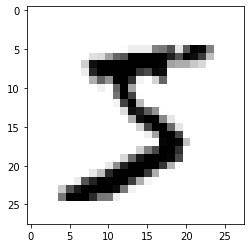

In [7]:
def plot_digit(digit):
    digit_prepared = digit.reshape(28,28)
    plt.imshow(digit_prepared, cmap="binary")
    plt.show()

plot_digit(X[0])

In [8]:
#mnist가 훈련세트랑 테스트세트는 이미 나누어 놨다..

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#3.2 이진 분류기 훈련

**이진 분류기**

- 예로 숫자 5만 식별해보자..

In [ ]:
#레이블이 5이면 True로 지정

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**확률적 경사 하강법(SGD)** 분류기로 시작해보자..

In [ ]:
#모델 만들고 훈련..

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#아까 데이터 확인.. 5니까 True..

sgd_clf.predict([first_data])

array([ True])

#3.3 성능 측정

##3.3.1 교차 검증을 사용한 정확도 측정

**성능측정 방법 1**

- 가끔 사이킷런이 제공하는 거 보다 더 많이 제어해야할 수도 있음
- 그럼 직접 구현해야함..
- StratifiedKFlod()메서드로 계층적 샘플링..

In [ ]:
#교차검증 직접구현..
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#3개로 나누고, 섞는다..
#이 객체의 split특성에 각 splits들의 훈련세트, 테스트세트 인덱스가 들어있다..
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#splits마다 모델을 clone해가지고 훈련시키고, 예측한다..
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_prediction_folds = clone_clf.predict(X_test_folds)
    #같은거 갯수찾고, 비율 확인..
    n_correct = sum(y_prediction_folds == y_test_folds)
    print(n_correct / len(y_prediction_folds))

0.9669
0.91625
0.96785


In [ ]:
#사이킷런 메서드 이용..

from sklearn.model_selection import cross_val_score, cross_validate

cross_validate(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)['test_score']
#cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

**분석**

- 모든 폴드에 대해 정확도가 엄청 높다..
- 하지만 이렇게 **불균형한 데이터셋**을 다룰때는 정확도가 성능을 제대로 측정하지 못한다..
    - 현재 True가 10%, False가 90%..
    - 다 False로 예측하면 정확도 90%는 먹고 시작함

In [ ]:
#무조건 False예측하는 모델..
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        #예측해야하는 길이만큼의 0의 2차원 리스트..
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
#90퍼는 먹고 감..
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

##3.3.2 오차 행렬

**성능측정 방법2**

**오차행렬**

- sklearn.metrics의 confusion_matrix함수 사용해서 구현
- 클래스 A 샘플이 클래스 B로 분류된 횟수를 세는 것
- ex) 숫자 5가 3으로 잘못 분류된 횟수를 알고 싶다.. -> 오차행렬의 5행 3열을 보면 된다!!
- **행 : 실제 클래스 / 열 : 예측 클래스**
- **진짜음성(TN)** / **진짜양성(TP)** / **거짓음성(FN)** / **거짓양성(FP)**

In [ ]:
#일단 오차행렬을 하려면 예측값이 있어야함..
#cross_val_predict()를 사용하면 각 테스트폴드에서 얻은 예측을 반환한다..
#method 매개변수 기본값 : "predict"

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [ ]:
#여기서는 index = 0 이 음성클래스..

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
##완벽한 분류기라면 대각성분만 남아있음..

y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

**정밀도**

- 양성 예측의 정확도
- $(진짜양성) / (양성으로 분류한 것들)$
- TP / (TP + FP)
- 양성으로 예측한 것 중에 진짜 양성인 것의 비율.. -> 얼마나 정확하게 예측했냐..

**재현율**

- 민감도 or 진짜 양성 비율
- 정확하게 감지한 양성 샘플의 비율
- $(양성으로 분류된 진짜 양성) / (전체 양성 샘플)$
- TP / (FN + TP)
- 진짜 양성이었던 것 중에 얼마나 양성으로 잘 분류되었는지의 비율..

##3.3.3 정밀도와 재현율

**성능측정 방법3**

정밀도, 재현율 및 다양한 지표를 계산하는 여러 함수가 많다..

In [ ]:
from sklearn.metrics import precision_score, recall_score

print("정밀도")
print(3530 / (3530 + 687))
print(precision_score(y_train_5, y_train_pred))

print()
print("재현율")
print(3530 / (1891 + 3530))
print(recall_score(y_train_5, y_train_pred))

정밀도
0.8370879772350012
0.8370879772350012

재현율
0.6511713705958311
0.6511713705958311


**F1 점수**

- 정밀도와 재현율의 조화평균
- 정밀도와 재현율이 비슷한 분류기는 F1점수가 높다
- 경우에 따라 정밀도 / 재현율 중 더 중요한 지표를 선택해야 한다..
    - 높은 정밀도 : 아이들을 위한 동영상을 거르는 작업
        - 분류하면 정확하게 분류해야 한다..
    - 높은 재현율 : 도둑을 잡는 분류기
        - 정확도는 떨어지더라도 도둑들을 다 잡아내는게 우선이다..

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


##3.3.4 정밀도/재현율 트레이드오프

**정밀도/재현율 트레이드오프**

- 정밀도와 재현율을 동시에 얻을 수는 없고, 이를 트레이드오프라고 한다..

- SGDClassifier는 **결정 함수**를 사용해서 각 샘플의 점수를 계산한다
- 이 점수가 **결정 임계값**보다 크면 양성, 작으면 음성으로 분류한다
- 이게 predict()함수의 하는 일..
- 이 **결정 임계값**에 따라 정밀도와 재현율이 달라진다..
    - **임계값이 증가하면 재현율은 항상 떨어진다**
    - **임계값이 증가하면 정밀도는 일반적으로 증가한다(그렇지 않을 때도 있다..)**
    - 반례 : p.137 [그림 3-3]

In [ ]:
#decision_function()메서드 호출하면 알 수 있다..

y_scores = sgd_clf.decision_function([first_data])
print(y_scores)

[2164.22030239]


In [ ]:
#임계값 조정하고 예측결과를 확인해보자..

print("임계값 : 0")
threshold = 0
y_first_data_pred = (y_scores > threshold)
print(y_first_data_pred)

print()
print("임계값 : 8000")
threshold = 8000
y_first_data_pred = (y_scores > threshold)
print(y_first_data_pred)

임계값 : 0
[ True]

임계값 : 8000
[False]


적절한 임계값을 위한 그래프 그리기

- cross_val_predict()로 결정함수값을 받아오기..
- precision_recall_curve 메서드 사용.. -> 매개변수로 타깃값과 결정함수값을 보내줌

In [ ]:
#결정함수 값 받아오기

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

In [ ]:
#인자로 타깃과 결정함수값을 넣음
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
#크기 한번 보자..
#precisions와 recalls 가 항상 1개 적다..  -> 마지막 정밀도 1, 재현율 0
#thresholds는 자동 오름차순정렬되고, 중복되면 자동 삭제된다..

print(precisions.shape)
print(recalls.shape)
print(thresholds.shape)

(59967,)
(59967,)
(59966,)


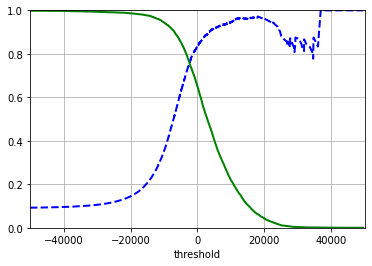

In [ ]:
#임계값에 따른 정밀도와 재현율 함수를 그리자..
#위의 크기에서 임계값이 하나 작은것을 볼수 있다.. -> 그래서 [:-1]인덱싱으로 끝에 하나를 뺀다

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
#predict()함수가 하는 일은 결정함수 값이 0보다 큰지를 확인하는 것..

(y_train_pred == (y_scores > 0)).all()

True

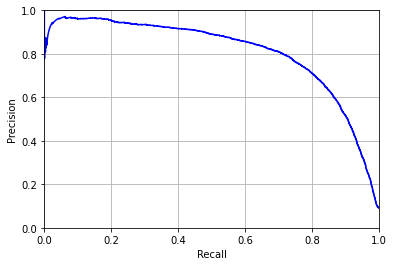

In [ ]:
#재현율에 대한 정밀도 곡선을 그리는 함수

def plot_recall_vs_precision(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plot_recall_vs_precision(precisions, recalls)
plt.show()

In [ ]:
# 정밀도/재현율 곡선아래의 면적을 구해주는 함수..
# 면적이 클수록 좋다..

from sklearn.metrics import average_precision_score
average_precision_score(y_train_5, y_scores)

0.810041762752646

**그래프 분석**

- 그래프 아래 면적이 클수록 좋다..
- 재현율이 80%근처에서 정밀도가 급격하게 줄어든다..
- 이 하강점 직전을 정밀도/재현율 트레이드오프 지점으로 선택하는 것이 좋다..
- 약 재현율 60%..??

**만약 목표가 있다면..?**

- 그 목표에 맞도록 임계값을 설정할 수 있다..
- 높은 정밀도가 목표라면 -> 임계값을 졸리 올리면 된다..
- 높은 재현율이 목표라면 -> 임계값을 졸리 낮추면 된다..

**하지만**

- 재현율이 너무 낮다면 높은 정밀도도 유용하지 않다..
- 반대도 마찬가지다..
- 따라서 항상 적당하게 해야한다..

In [ ]:
#정밀도 90%이상이 목표일때 임계값을 저장..

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [ ]:
#지정 임계값이 넘는 것만 True

y_train_pred = (y_scores >= threshold_90_precision)

In [ ]:
#새로운 예측에 대한 오차행렬

confusion_matrix(y_train_5, y_train_pred)

array([[54290,   289],
       [ 2819,  2602]])

In [ ]:
#재현율 정밀도 확인..
print("정밀도")
print(2602 / (2602 + 289))
print(precision_score(y_train_5, y_train_pred))

print()
print("재현율")
print(2602 / (2602 + 2819))
print(recall_score(y_train_5, y_train_pred))

정밀도
0.9000345901072293
0.9000345901072293

재현율
0.4799852425751706
0.4799852425751706


##3.3.5 ROC 곡선

**성능측정 방법4**

**수신기 조작 특성(ROC)**

- **거짓양성비율(FPR)**
    
    - 전체 음성 샘플중에서 양성으로 잘못 분류된 것의 비율
    - FP / (FP + TN) 

- **진짜음성비율(TNR)**
    - **특이도**와 같은 말
    - 전체 음성 샘플중에서 진짜 음성으로 잘 분류된 것의 비율
    - TN / (FP + TN)
- FPR + TNR = 1

- **진짜양성비율**
    - 재현율과 동일
- **거짓양성비율(FPR)**에 대한 **진짜양성비율(TPR)**


In [ ]:
#ROC 곡선 그리려면 FPR, TPR값을 알아야한다..
#roc_curve() 메서드에 레이블과 결정함수 값을 전달하면 
#각 임계값에 대한 fpr, tpr값을 알려준다..

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

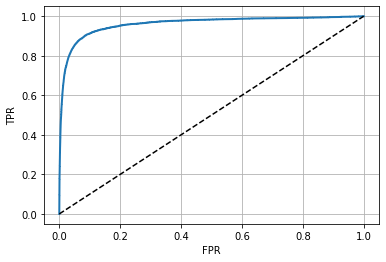

In [ ]:
#roc곡선 그리는 함수

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

**트레이드오프 존재**

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 많아진다..
- 점선은 완전한 랜덤분류기..
- 곡선이 왼쪽 위로 붙을수록 좋은 분류기이다
    - 거짓양성도 없으면서, 재현율도 좋다

**곡선 아래의 면적(AUC)**

- 완벽분류기 : 1 / 랜덤분류기 : 0.5
- **클수록 좋다!!**
- roc_auc_score 메서드로 계산가능

In [ ]:
#곡선아래의 면적.. 클수록 좋다!!

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
#랜덤포레스트 분류기를 만들고 성능을 roc곡선으로 측정해보자..
#roc_curve()메서드에 레이블과 확률을 주어야한다.. 
#얘의 예측값은 predict_proba()함수로 얻을 수 있다.. -> 각 클래스일 확률을 반환한다

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method="predict_proba", n_jobs=-1)

In [ ]:
#양성클래스일 확률만 받아온다..
#그리고 그 확률에 대한 fpr, tpr을 구한다..

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

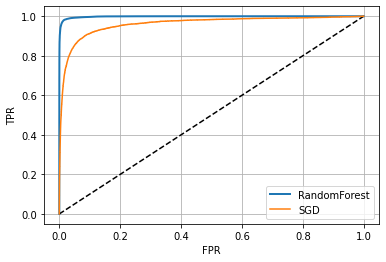

In [ ]:
#앞에거랑 같이 그려보자..

plot_roc_curve(fpr_forest, tpr_forest, label="RandomForest")
plt.plot(fpr, tpr, label="SGD")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#AUC면적도 더 크다..

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

**그래프 분석**

- 랜덤포레스트가 SGD 분류기보다 더 좋다..
- 그래프가 왼쪽위로 붙어있고, 곡선 아래 면적도 더 크다

**랜덤포레스트의 정밀도와 재현율 확인**

- 새로운 예측을 만든다.. -> cross_val_predict()
- 오차행렬로 확인
- 혹은 재현율, 정밀도를 구해주는 메서드 사용..

In [ ]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict", n_jobs=-1)

confusion_matrix(y_train_5, y_pred_forest)

array([[54534,    45],
       [  725,  4696]])

In [ ]:
#정밀도 재현율 둘다 붸리 굿..

print("정밀도")
print(4735 / (4735 + 43))
print(precision_score(y_train_5, y_pred_forest))

print()
print("재현율")
print(4735 / (4735 + 686))
print(recall_score(y_train_5, y_pred_forest))

정밀도
0.9910004185851821
0.9905083315756169

재현율
0.8734550820881756
0.8662608374838591


**TIP**

- 정밀도/재현율 곡선 사용
    - 양성 클래스가 드물게 있을 때..
    - 거짓 음성보다 거짓 양성이 더 중요할때..
    - 분류기의 성능 개선 여지가 얼마나 되는지 (얼마나 오른쪽 위 모서리에 가까워질 수 있는지)를 잘 보여준다..

- ROC 곡선 사용
    - 나머지 경우..

#3.4 다중 분류

**다중 분류기**

- 여러 개의 클래스 직접 처리가능
    - SGD분류기, 랜덤포레스트 분류기, 나이브 베이즈 분류기..
- 이진 분류만 가능
    - 로지스틱 회귀, 서포트 벡터 머신 분류기..

이진 분류기를 여러개 사용해서 다중 클래스를 분류하기

- **OvR**
    - 각 클래스와 아닌 것들로 분류하는 이진분류기를 클래스 갯수만큼 만든다
    - 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택한다..
    - 대부분의 분류기가 사용하는 방식..

- **OvO**
    - 각 클래스의 조합마다 이진 분류기를 훈련시킨다..
    - 클래스가 N개면, N * (N-1) / 2 만큼의 이진 분류기가 필요하다..
    - 모든 분류기를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택한다..
    - 장점 : **각 분류기의 훈련에 전체 훈련세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다**
    - 서포트 벡터 머신 분류기가 선호하는 방식..

사이킷런이 자동으로 OvR 혹은 OvO를 실행한다..

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
#다중 클래스 레이블로 훈련..
svm_clf.fit(X_train, y_train)
svm_clf.predict([first_data])

array([5], dtype=uint8)

In [ ]:
first_data_scores = svm_clf.decision_function([first_data])
print(first_data_scores)

#first_data_scores에서 가장 큰 값의 인덱스 출력..
print(np.argmax(first_data_scores))

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5


In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

강제로 OvR, OvO방식을 지정하려면..

- OneVsOneClassifier 혹은 OneVsRestClassifier 사용..

In [ ]:
#SVC를 OvR전략을 사용하도록 만들자..
#와이래 오래걸리노..

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([first_data])

array([5], dtype=uint8)

In [ ]:
#SGD혹은 랜덤포레스트 분류기를 훈련시키는거도 간단..
#자동으로 SGD는 OvR방식으로 훈련..

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([first_data])

array([3], dtype=uint8)

In [ ]:
#각 클래스마다 부여한 결정 점수값 확인..

sgd_clf.decision_function([first_data])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**결과 확인**

- 책 기준..
    - 클래스 3의 점수 : 573.5  /  클래스 5의 점수 : 2412.5
    - 3을 조금 의심하고 있다..
- 실제로는..
    - 클래스 3의 점수 : 1823.7  /  클래스 5의 점수 : -1385.8
    - 잘못 예측했다..


**정확도 평가**

- cross_val_score()함수 사용..

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

스케일링 해주면 좀 더 나은 정확도를 얻을 수 있다..

In [ ]:
#테스트 성능이 좀 좋아졌다..

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

#3.5 에러 분석

- 원래는 아래의 과정을 해야한다..
    - 데이터 준비 단계에서 가능한 선택사항을 탐색
    - 여러 모델을 시도
    - 가장 좋은 몇 개를 골라서 그리드/랜덤 서치로 하이퍼파라미터 튜닝..
    - 가능한 한 자동화..
- 이미 좋은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 높이는 방법을 찾아보겠다!!

**오차행렬 확인**

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

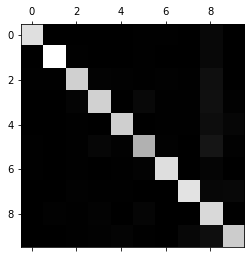

In [ ]:
# 이미지로 표현..
#cmap = plt.cm.gray : 숫자가 클수록 밝음

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 에러에 집중해보자..

#각 행의 합을 구하고
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)

#각 행의 합으로 모든 원소를 나눈다..
norm_conf_mx = conf_mx / row_sums

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


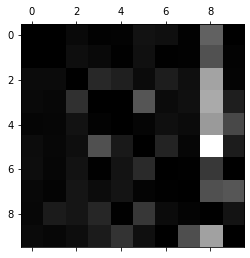

In [ ]:
# 주대각선을 0으로 바꾼다.. (에러에만 집중하기 위해서)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**분석**

- 클래스 8열이 상당히 밝다.. -> 많은 이미지가 8로 잘못 분류되었다!!
- 오차행렬이 반드시 대칭일 필요는 없다
- 3행 5열과 5열 3행이 밝다.. -> 3과 5가 서로 많이 혼동된다고 볼 수 있다

오차 행렬을 분석해서 성능 향상 방안에 대한 통찰을 얻을 수 있다..

- 8을 좀 더 잘 구분해보자..
    - 8처럼 보이는 훈련데이터를 더 모은다 던가..
    - 동심원의 수를 세는 알고리즘을 도입한다 던가..

3과 5의 샘플을 한 번 그려보자..

In [ ]:
#내가한거.. 오류가 난다..

def plot_digits(digits, image_per_row=5):
    #들어오는 digits 샘플이 5의 배수라고 가정..
    digits_prepared = [digit.reshape(28,28) for digit in digits]
    fig, axs = plt.subplot(len(digits)//5, 5)
    for i in range(len(digits)//5):
        for j in range(5):
            axs[i][j].imshow(digits_prepared[i*5+j], cmap="binary")
            axs[i][j].axis('off')

In [ ]:
def plot_digits_by_book(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

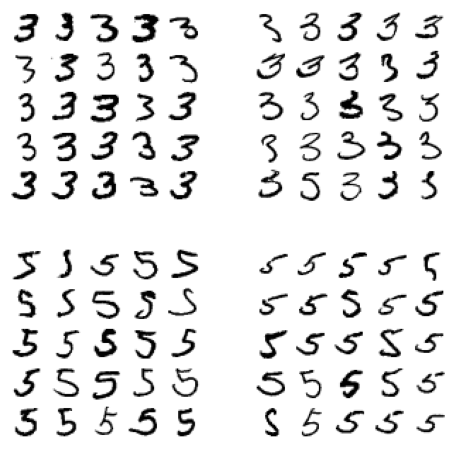

In [ ]:
#클래스 잡아놓고
cl_a, cl_b = 3, 5

#3인데 3으로 예측한 거
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
#3인데 5로 예측한 거
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
#5인데 3으로 예측한 거
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
#5인데 5로 예측한 거
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits_by_book(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits_by_book(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits_by_book(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits_by_book(X_bb[:25], images_per_row=5)
plt.show()

**분석**

- 대부분의 잘못 분류된 이미지는 확실히 에러이고, 실수한 이유를 이해하기 어렵다,..
- 원인은 선형모델인 SGDClassifier를 사용했기 때문..
    - 선형 분류기는 클래스마다 픽셀에 가중치를 할당함
    - 픽셀강도의 가중치합을 클래스의 점수로 계산함..
    - 결과적으로 3, 5 는 픽셀 자체가 비슷하기 때문에 모델이 쉽게 혼동함..

- 3과 5의 경우에는..
    - 주된 차이가 5의 직선의 유무이다..
    - **분류기는 이미지의 위치나 회전 방향에 매우 민감**
    - **이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리**하면 에러가 많이 준다..

**정리**

- 픽셀로 구별을 하는데 픽셀이 비슷해서 쉽게 혼동..
- 중앙에 고정시키고, 회전방향을 고정하는 등 전처리를 통해 에러를 줄일 수 있다

#3.6 다중 레이블 분류

- 여러 개의 이진 꼬리표를 출력하는 분류 시스템..
- ex) 큰 숫자인지와 홀수인지를 동시에 예측하는 분류기..

여기서 KNN은 다중 레이블 분류를 지원하지만 다 그런건 아님..

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
#큰 수인지랑 홀수인 컬럼붙혀서 가져온다..
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#이제 예측을 2가지를 한다.. (큰 수인지, 홀수인지..)
knn_clf.predict([first_data])

array([[False,  True]])

**다중 레이블 분류기 평가**

- 방법은 많고, 적절한 방법은 케바케..
- 여기서는 예시로 각 레이블의 F1점수를 평균하는 방법을 썼다..
    - average 매개변수
        - 어떻게 평균낼 지를 결정..
        - "macro" : 각 레이블당 샘플수가 다를때, 그 각 레이블마다의 가중치를 고려하지 않고 그냥 무지성 평균..
        - "weighted" : 각 레이블 마다의 가중치(지지도)를 고려해서 평균,,
    - **지지도**
        - 타깃 레이블에 속한 샘플수

In [ ]:
#이거도 엄청 오래걸림..

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

#3.7 다중 출력 분류

- 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것..
- 예시
    - 잡음을 넣어서 새로운 X_train_mod를 만든다..
    - 데이터셋 자체가 레이블이 되도록함..
    - 784개의 픽셀로 이루어짐..
    - 다중 출력 분류의 예!!

In [ ]:
#잡음을 생성해서 원본에서 더해서 준비..
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = noise + X_train
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = noise + X_test

#원래거를 레이블로 준비..
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
#최근접 이웃으로 훈련..
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

잡음 데이터


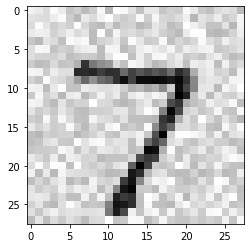

예측 결과


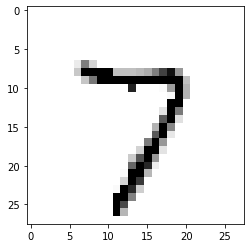

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[0]])
clean_digit_2 = knn_clf.predict([X_train_mod[0]])

#잡음 낀 데이터 출력
print("잡음 데이터")
plot_digit(X_test_mod[0])

#예측결과 출력
print("예측 결과")
plot_digit(clean_digit)

# 추가 내용

##더미 (랜덤) 분류기

- 멍텅구리 클래스 : 다른 분류기랑 비교할때 사용
- strategy의 기본값이 stratified -> prior로 바뀜..

In [ ]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)
#양성일 확률만 가져온다..
y_scores_dmy = y_probas_dmy[:, 1]

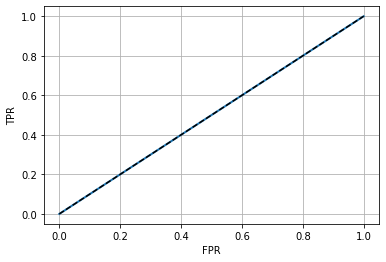

In [ ]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

##KNN 분류기

- weights='distance'이면 가까운 샘플에 대해서는 가중치를 더 준다..

In [ ]:
knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
#정확도 확인..
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

###그림을 이동시키는 함수..

**scipy.ndimage.interpolation의 shift함수..**

- 매개변수를 [dy, dx]를 보내야한다..
- mode 매개변수 : 빈부분을 채우는 방법
    - constant, nearest, reflect, wrap
- 변경된 범위에서 그대로 그림을 그리고, 원래 범위대로 출력한다..
    - ex) 가로픽셀 0 ~ 28 -> -5 ~ 23, 출력은 0 ~ 28범위 그대로.. 즉, 왼쪽으로 이동한 결과..

In [18]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28,28), [dy, dx], cval=new,mode="constant").reshape(784)

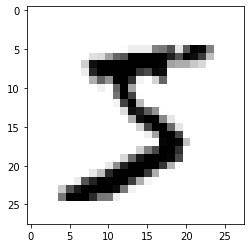

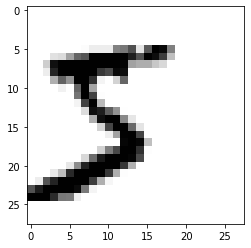

In [10]:
plot_digit(first_data)
#음양 상관없음.. -> 변경된 범위에서 그대로 숫자를 쓰고, 원래 범위를 출력한다..
#가로픽셀 0~28 -> -5~23
#가로픽셀 0~28 -> 1~29
#세로픽셀 0~28 -> 5~32
#근데 출력은 그대로 가로세로 각각 0~28씩 된다..
plot_digit(shift_digit(first_data, -5, 0,new = 0))

####**axis, apply_along_axis(), concatenate() 관련 연습..**

In [ ]:
p = np.array([[1,2,3],[4,5,6],[7,8,9]])
q = np.apply_along_axis(sum, 1, p)
print(q)

[ 6 15 24]


In [ ]:
a = np.array([[[0,1,2],[3,4,5],[6,7,8]],[[9,10,11],[12,13,14],[15,16,17]]])
print(a)
print(a.shape)
print()
b = np.apply_along_axis(sum, 0, a)
print(b)
print(b.shape)
print()
c = np.apply_along_axis(sum, 1, a)
print(c)
print(c.shape)
print()
d = np.apply_along_axis(sum, 2, a)
print(d)
print(d.shape)

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]]
(2, 3, 3)

[[ 9 11 13]
 [15 17 19]
 [21 23 25]]
(3, 3)

[[ 9 12 15]
 [36 39 42]]
(2, 3)

[[ 3 12 21]
 [30 39 48]]
(2, 3)


In [ ]:
s = np.array([[1,2,3], [4,5,6]])
q = np.array([[7,8,9],[10,11,12]])
print(np.concatenate((s,q), axis=0))
print(np.concatenate((s,q), axis=1))

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]]


In [19]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1,0),(-1,0),(0,1),(0,-1)):
    shifted_images = np.apply_along_axis(shift_digit, 1, X_train, dx,dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    print(np.array(X_train_expanded).shape)

(2, 60000, 784)
(3, 60000, 784)
(4, 60000, 784)
(5, 60000, 784)


In [20]:
#axis=0 기본값으로 갖다 붙혔다..

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

###**모델로 다시 예측해보자..**

In [13]:
#많아진 훈련세트..
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
#이거도 엄청 오래걸린다..

y_knn_expanded_pred = knn_clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_expanded_pred)

0.9754

애매한 샘플도 함 해보자..

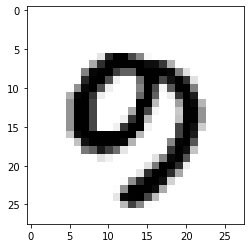

In [17]:
ambiguous_digit = X_test[2589]
plot_digit(ambiguous_digit)

In [18]:
print(knn_clf.predict([ambiguous_digit]))
print(y_test[2589])

[9]
9


#3.8 연습문제

##1번

MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97%의 정확도를 달성해보세요.

- 힌트 : KNeighborsClassifier가 좋은 모델이고, 좋은 파라미터값만 찾으면 된다..
- 그리드 탐색을 해봐라

In [10]:
#너무 오래걸리는데..
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf_practice = KNeighborsClassifier()

params = [
        {'weights' : ["uniform", "distance"]},
        {'n_neighbors' : [3,4,5]}
]
gs_Classifier = GridSearchCV(knn_clf_practice, params, cv=3, n_jobs=-1)
gs_Classifier.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'weights': ['uniform', 'distance']},
                         {'n_neighbors': [3, 4, 5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [11]:
gs_Classifier.best_params_

{'weights': 'distance'}

In [12]:
gs_Classifier.best_score_

0.9686

In [14]:
#테스트세트 정확도 체크
from sklearn.metrics import accuracy_score

y_test_pred_practice = gs_Classifier.predict(X_test)
accuracy_score(y_test, y_test_pred_practice)

0.9691

##2번

**데이터 증식**

: 인위적으로 훈련 세트를 늘리는 기법

- MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어라

- 훈련세트의 각 이미지에 대해 네 개의 이동된 복사본을 만들어서 훈련 세트에 추가해라

- 확장된 훈련세트에 대해서 앞의 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 측정해라

In [21]:
#위의 결과로 X_train_expanded, y_train_expanded에 저장되어있음..
#최고의 파라미터를 전달해서 새로운 분류기를 만들고
#증식된 데이터로 훈련시킴..

knn_best = KNeighborsClassifier(**gs_Classifier.best_params_)
knn_best.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [ ]:
#테스트세트 정확도 예측..

y_knn_expanded_pred = knn_best.predict(X_test)
accuracy_score(y_test, y_knn_expanded_pred)

##3번

##4번